## The project consists of following steps:

### Importing libraries

In [1]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage
import copy

In [2]:
from collections import deque
import numpy as np
import argparse
import cv2
import imutils
import time
import matplotlib.pyplot as plt

### Defining Necessary threshold and other variables to select color mask and the location of the Balls

In [3]:
greenUpper=(93,174,101)
greenLower=(73,22,60)

yellowUpper=(34,255,185)
yellowLower=(24,136,88)

whiteLower=(20,21,131)
whiteUpper=(85,44,230)

redLower=(4,68,147)
redUpper=(10,211,255)




In [4]:
white_ball={'Lower':(20,21,131),
            'Upper':(85,44,230),
           'Quadrant':-1}

green_ball={'Lower':(73,22,60),
            'Upper':(93,174,101),
           'Quadrant':-1}

yellow_ball={'Lower':(24,136,88),
            'Upper':(34,255,185),
           'Quadrant':-1}

red_ball={'Lower':(4,68,147),
            'Upper':(10,211,255),
           'Quadrant':-1}



### Loading the video from the path

In [5]:

vid_path= r"C:\Users\TanmayPrakash\Downloads\Nism\AI_Assignment_video.mp4"
vs = cv2.VideoCapture(vid_path)

In [6]:
# checking the various metadata related to the frames shuch as FPS, frame width and frame height.
if (vs.isOpened() == False):
    print("Error opening the video file")
else:
    # Get frame rate information

    fps = int(vs.get(5))
    print("Frame Rate : ",fps,"frames per second")  

    # Get frame count
    frame_count = vs.get(7)
    print("Frame count : ", frame_count)

    frame_width= vs.get(3)
    print("Frame width: ", frame_width)

    frame_height= vs.get(4)
    print("frame height: ", frame_height)
    
mf= frame_width/400

Frame Rate :  30 frames per second
Frame count :  3183.0
Frame width:  1920.0
frame height:  1080.0


### Method 1 for grid detection:A simple utility function to manually provide the edge coordinates of the bounding box(grid), It requires Human intervention

The utility function reads the first frame of the video and asks for the coordinates of the points on grid to determine the coordinate system. Use the mouse to click on the required points in the pop-up window opened. Press 'Q' to close the window after choosing the suitable points.

In [7]:
# coordinate_lst=[]
# def click_event(event, x, y, flags, params):
#     if event == cv2.EVENT_LBUTTONDOWN:
#         print("(x,y)={},{}".format(x,y))
#         # put coordinates as text on the image
#         cv2.putText(img,str(x)+','+str(y) ,(x,y),
#         cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)

#         # draw point on the image
#         cv2.circle(img, (x,y), 3, (0,255,255), -1)
#         x=int(x*mf)
#         y=int(y*mf)
#         coordinate_lst.append((x,y))
        
 
# # read the input image
# img = vs.read()[1]
# img = cv2.flip(img,0)
# img = cv2.flip(img,1)
# img= imutils.resize(img,400)
# mf= frame_width/400
# # create a window
# cv2.namedWindow('Point Coordinates')

# # bind the callback function to window
# cv2.setMouseCallback('Point Coordinates', click_event)

# # display the image
# while True:
#     cv2.imshow('Point Coordinates',img)
#     if cv2.waitKey(10) & 0xFF == ord('q'):
#         break

# cv2.destroyAllWindows()


# for coordinates in coordinate_lst:
#     print(coordinates)

### Method 2 for grid detection: Harris Corner Detection method, automated, no human intervention required

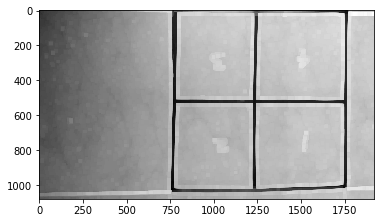

In [8]:
img = vs.read()[1]
img = cv2.flip(img,0)
img = cv2.flip(img,1)


gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
gray = np.float32(gray)
gray= ndimage.maximum_filter(gray,20) # Maximim filter used to supress artifacts giving false corners.

plt.imshow(gray, cmap='gray') #Gray scale image to be used for corner detection




1773 1046
743 3


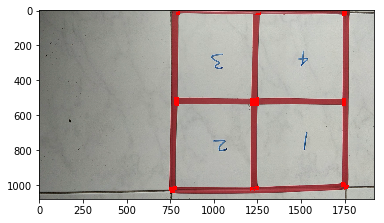

In [9]:
corners = cv2.cornerHarris(gray, 30, 5, 0.05) # Harris corner detection algo

coordinates=np.argwhere(corners > 0.05 * corners.max())

x_max= coordinates.max(axis=0)[1]
x_min=coordinates.min(axis=0)[1]

y_max= coordinates.max(axis=0)[0]
y_min= coordinates.min(axis=0)[0]

tmp_img= copy.deepcopy(img)
tmp_img[corners> 0.05*corners.max()]=[0,0,255]
plt.imshow(tmp_img[:,:,::-1])

print(x_max, y_max)
print(x_min, y_min)

In [10]:
# x_coordinates=[]
# y_coordinates=[]

# for x,y in coordinate_lst:
#     x_coordinates.append(x)
#     y_coordinates.append(y)
    
    
# x_max=max(x_coordinates)
# y_max=max(y_coordinates)

# x_min= min(x_coordinates)
# y_min= min(y_coordinates)

x_mean= int((x_max+x_min)/2)
y_mean= int((y_max+y_min)/2)

print(x_mean, y_mean)


1258 524


### Various Utility functions

In [11]:
#Function to Get the current quadrant of the Ball Based on its x and y coordinates
def gen_quadrant(x,y):
    if x < x_min or x>x_max or y<y_min or y>y_max:
        qdr=-1
        
    elif x<x_mean and y< y_mean:
        qdr= 3
    
    elif x> x_mean and y<y_mean:
        qdr=4
        
    elif x< x_mean and y> y_mean:
        qdr=2
        
    elif x>x_mean and y>y_mean:
        qdr=1
    else:
        qdr=-1
        
    return qdr

# Function to check is the quadrant of the ball has changed
def check_change_qdr(old_qdr, new_qdr):
    return old_qdr!=new_qdr

#Function to update the quadrant of the ball
def update_qdr(new_qdr, color):
    if color=='w':
        white_ball['Quadrant']=new_qdr
    
    elif color=='y':
        yellow_ball["Quadrant"]=new_qdr
        
    elif color=='r':
        red_ball['Quadrant']=new_qdr
        
    elif color=='g':
        green_ball['Quadrant']=new_qdr

#Function to get the present Quadrant of the ball        
def fetch_quadrant(color):
    if color=='w':
        qdr= white_ball['Quadrant']
    
    elif color=='y':
        qdr= yellow_ball["Quadrant"]
        
    elif color=='r':
        qdr=red_ball['Quadrant']
        
    elif color=='g':
        qdr=green_ball['Quadrant']
        
    return qdr


Messages=[] # List to keep the logs of the Events

#Function to generate suitable Log based on the event of cgnage in quadrant
def get_message(new_qdr, old_qdr, color, time_stamp):

    time_stamp=round(time_stamp,2)
    if old_qdr==-1:
        message1="{}, {}, {}, Enter".format(time_stamp,new_qdr,color)
        Messages.append(message1)

        return message1
        
    elif new_qdr==-1:
        message1="{}, {}, {}, Exit". format(time_stamp,old_qdr, color)
        Messages.append(message1)
        return message1

    else:
        message1="{}, {}, {},Exit".format(time_stamp,old_qdr,color)
        message2="{}, {}, {},Enter".format(time_stamp,new_qdr,color)
        Messages.append(message1)
        Messages.append(message2)
        return message1 + " "+ message2
    

In [12]:
#Main function where each frame is processed, Appropriate Evnet is detected.
#This function is responcible for Object detection and tracking using masks as well.

def process(image,colorLower,colorUpper, color, time_stamp=0):
    
#     blurred = cv2.GaussianBlur(image, (11, 11), 0)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    mask = cv2.inRange(hsv, colorLower, colorUpper)
    mask = cv2.erode(mask, None, iterations=5)
    mask = cv2.dilate(mask, None, iterations=10)
    mask=ndimage.minimum_filter(mask, size=10)
    cnts= cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
    cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
#     cv2.drawContours(image, cnts, -1, (0,255,0), 5)
    if len(cnts) > 0:
        c = max(cnts, key=cv2.contourArea)
        if (len(c)>20):
            #print('length of cntr:',len(c))
            ((x, y), radius) = cv2.minEnclosingCircle(c)
            x=int(x)
            y=int(y)
            radius=int(radius)
            center=(int(x), int(y))
    #         print(center)
            color_val=image[y,x].astype('int')
            color_val=(int(color_val[0]),int(color_val[1]),int(color_val[2]))
            cv2.circle(image,center,radius,color_val,3)
            cv2.putText(image,color,(int(x+1.2*radius), int(y+1.2*radius)),cv2.FONT_HERSHEY_SIMPLEX,3,(255, 0, 0),2,cv2.LINE_AA)
            new_qdr=gen_quadrant(x,y)
            old_qdr=fetch_quadrant(color)
            cv2.circle(image, (x_mean,y_mean), radius=0, color=(0, 0, 255), thickness=-1)
            if check_change_qdr(old_qdr, new_qdr):
                message=get_message(new_qdr, old_qdr, color,time_stamp)
#                 print(message,center)
                cv2.putText(image,message,(200,1000),cv2.FONT_HERSHEY_SIMPLEX,3,(255, 0, 0),2,cv2.LINE_AA)
                update_qdr(new_qdr, color)
        
    else:
        old_qdr=fetch_quadrant(color)
        new_qdr=-1
        if check_change_qdr(old_qdr, new_qdr):
            message=get_message(new_qdr, old_qdr, color,time_stamp)
            cv2.putText(image,message,(200,1000),cv2.FONT_HERSHEY_SIMPLEX,3,(255, 0, 0),2,cv2.LINE_AA)
            update_qdr(new_qdr, color)
            
    #         plt.imshow(image[:,:,::-1])

In [13]:
frame_width = int(vs.get(3))
frame_height = int(vs.get(4))
   
size = (int(frame_width/mf), int(frame_height/mf))
result = cv2.VideoWriter('edit.mp4', 
                         cv2.VideoWriter_fourcc(*'XVID'),
                         vs.get(5), size)
i=0
#Loop to read each frame one-by-one and dend it for further processing
while True:

    frame = vs.read()
    frame = frame[1]
    frame = cv2.flip(frame,0)
    frame = cv2.flip(frame,1)
    if frame is None:
        break
    time_stamp=vs.get(cv2.CAP_PROP_POS_MSEC)
    process(frame,whiteLower,whiteUpper,'w',time_stamp)
    process(frame,greenLower,greenUpper, 'g',time_stamp)
    process(frame,yellowLower,yellowUpper,'y',time_stamp)
    process(frame,redLower,redUpper,'r',time_stamp)
#     plt.imshow(frame[:,:,::-1])
    frame=imutils.resize(frame,400)
    result.write(frame)
vs.release()    
result.release() 

In [14]:
# code snippet to Write the message logs into a text file
file = open('events.txt','w')
for message in Messages:
    file.write(message+"\n")
file.close()